# Importing Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Loading Dataset

In [2]:
data = pd.read_csv('human_vital_signs_dataset_2024.csv')

In [3]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Exploratory Data Analysis 

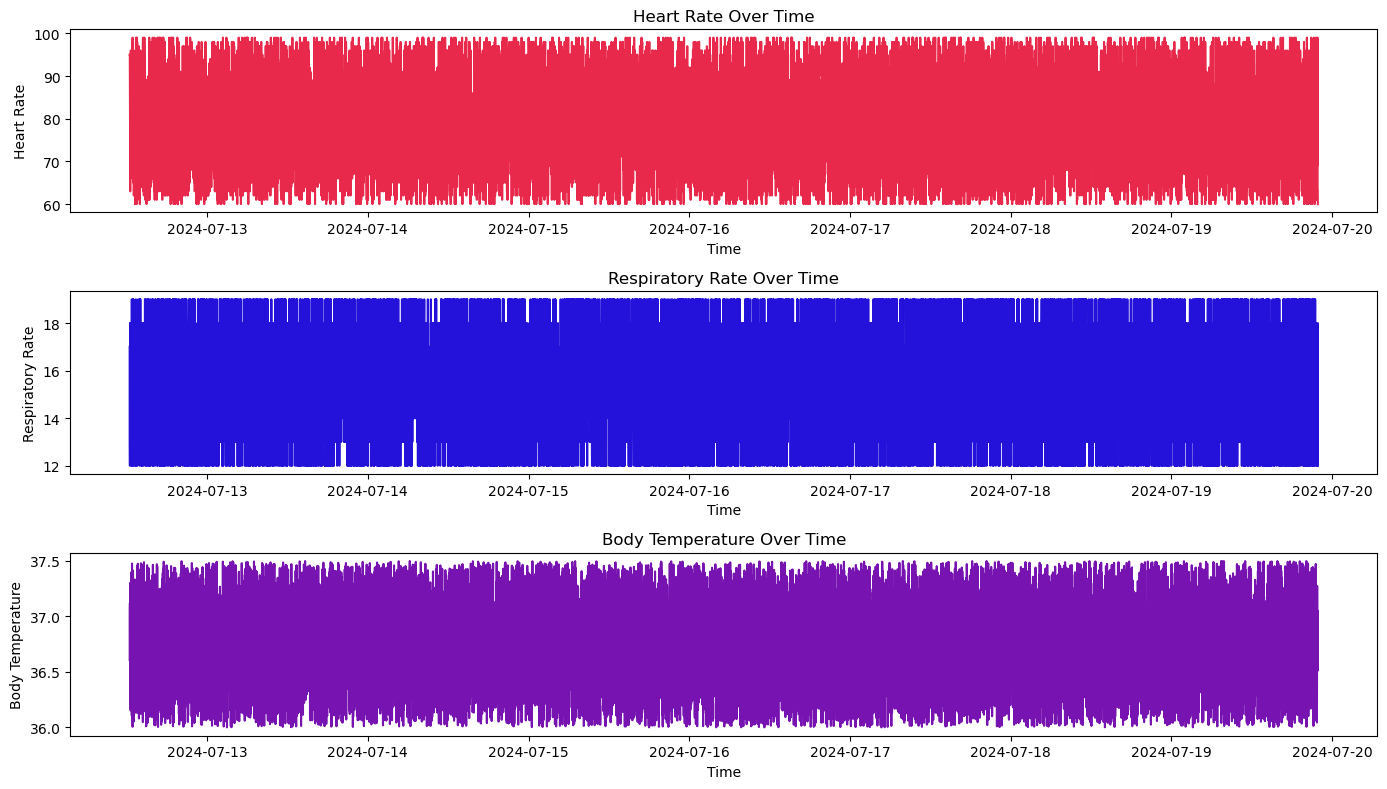

In [4]:
# Plot trends of key vital signs over time
plt.figure(figsize=(14, 8))
for i, col in enumerate(['Heart Rate', 'Respiratory Rate', 'Body Temperature']):
    plt.subplot(3, 1, i+1)
    plt.plot(data.index, data[col], color=np.random.rand(3,))
    plt.title(f'{col} Over Time')
    plt.xlabel('Time')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

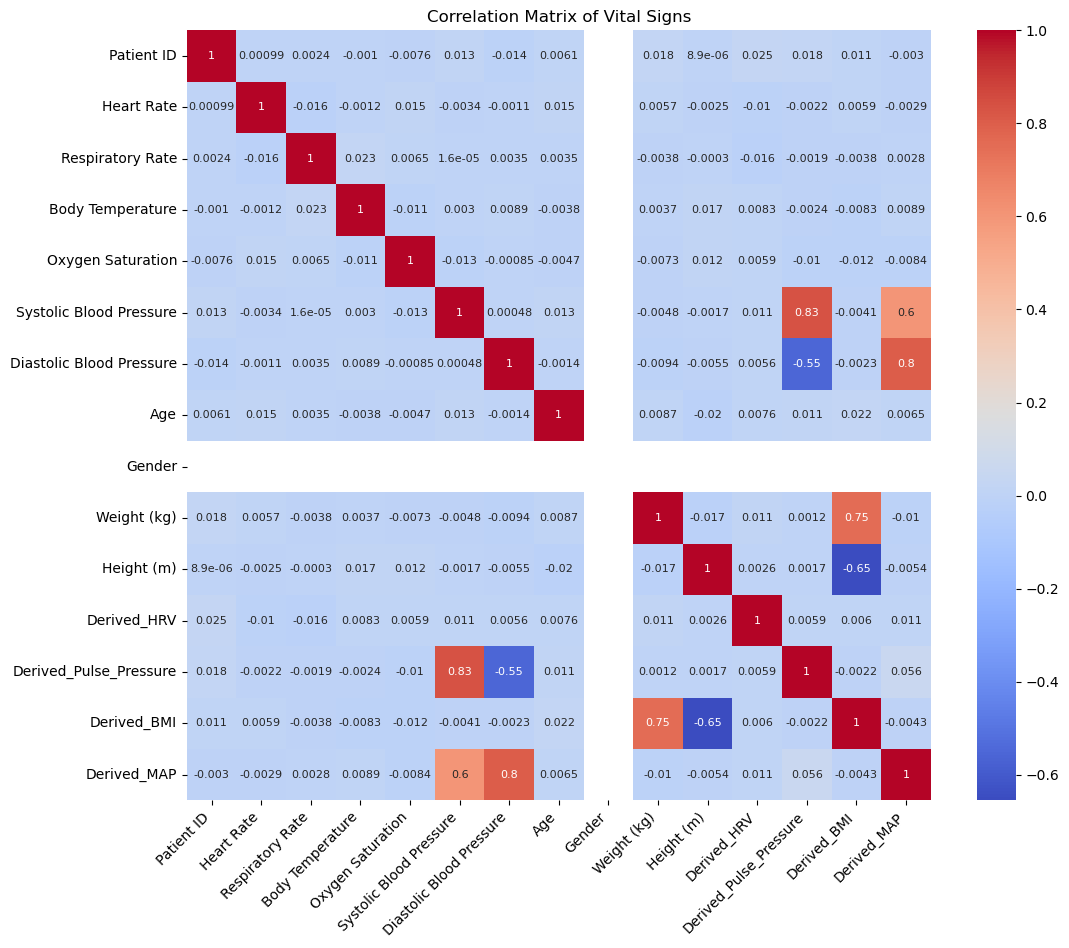

In [7]:
# Convert 'Gender' to numeric (e.g., Female=0, Male=1)
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})

# Now generate the correlation matrix as before
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8})  # Adjust font size
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.title("Correlation Matrix of Vital Signs")
plt.show()


# Data Preprocessing 

In [9]:
# Separate numeric and non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Adjust based on actual numeric types
non_numeric_data = data.select_dtypes(exclude=['float64', 'int64'])

# Resample and interpolate only on numeric data
data_resampled = numeric_data.resample('H').mean().interpolate(method='linear')

# Add back non-numeric data if needed, perhaps with forward fill
data_resampled = data_resampled.join(non_numeric_data.resample('H').ffill())


In [11]:
from sklearn.preprocessing import StandardScaler

# Separate numerical and categorical data
numeric_data = data_resampled.select_dtypes(include=[np.number])  # Select only numeric columns

# Standardize the numeric data
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(numeric_data)

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_data = pd.DataFrame(scaled_numeric_data, columns=numeric_data.columns, index=numeric_data.index)

# Combine scaled numeric data with the original categorical columns if needed
scaled_data = pd.concat([scaled_numeric_data, data_resampled.select_dtypes(exclude=[np.number])], axis=1)

C:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


# LSTM Model Building 

In [12]:
# Define a function to create sequences for LSTM input
def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [13]:
# Set sequence length (e.g., 24 hours) and split data
sequence_length = 24
X, y = create_sequences(scaled_data['Heart Rate'].values, sequence_length)

# Train-Test Split 

In [14]:
# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [15]:
#Build the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\Users\arshi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [21]:
# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.9674 - val_loss: 1.4649
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7935 - val_loss: 1.4818
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9385 - val_loss: 1.5107
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9412 - val_loss: 1.5461
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9477 - val_loss: 1.5532


# Evaluation Metrics

In [22]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test Mean Squared Error: 0.8664


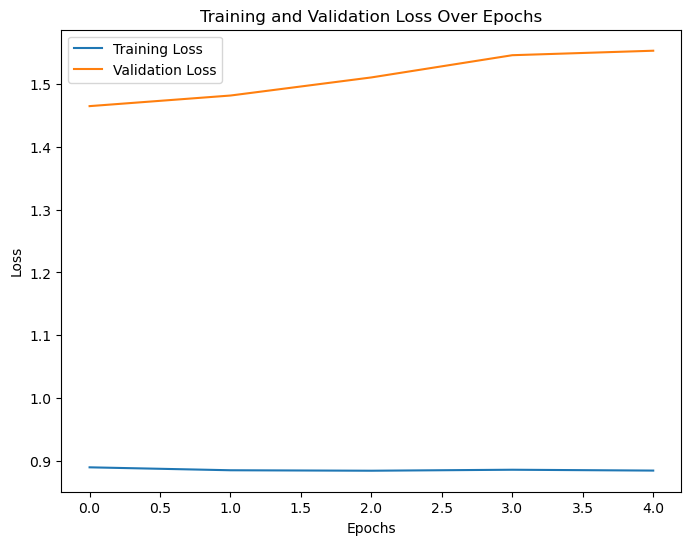

In [25]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

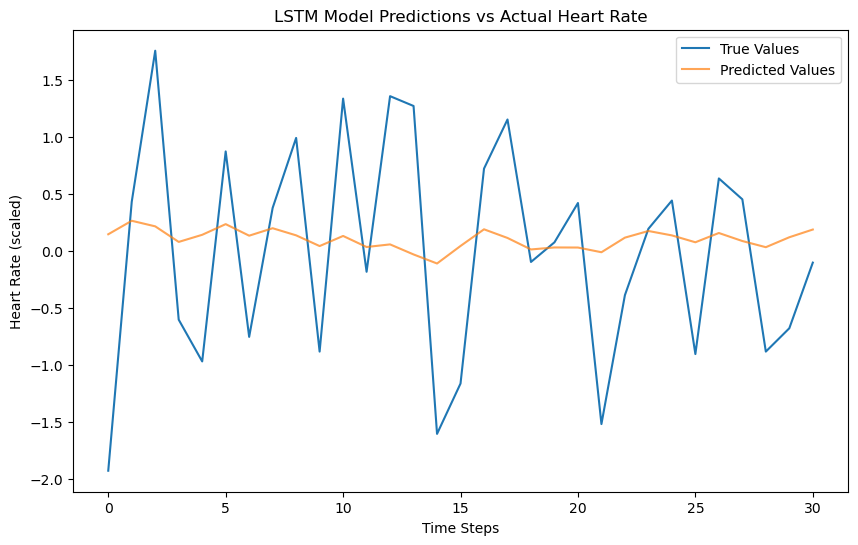

In [24]:
# Visualize Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values', alpha=0.7)
plt.title("LSTM Model Predictions vs Actual Heart Rate")
plt.xlabel("Time Steps")
plt.ylabel("Heart Rate (scaled)")
plt.legend()
plt.show()